# Set of experiments for the TTS task with given voice and task

In [1]:
from transformers import pipeline
import torchaudio
from speechbrain.inference.speaker import EncoderClassifier
import numpy as np
import torch

In [2]:
FILENAME = 'fFLVyWBDTfo.wav'
OUTPUT_PATH = '../data/audios'

In [3]:
# classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="../pretrained_models/spkrec-xvect-voxceleb")
# audio, sr = torchaudio.load(f'{OUTPUT_PATH}/{FILENAME}')
# embeddings = classifier.encode_batch(audio)

In [4]:
# embeddings.size()

In [5]:
# np.savetxt(f"{OUTPUT_PATH}/{'.'.join(FILENAME.split('.')[:-1])}_embeddings.txt", embeddings.squeeze().numpy())

In [6]:
# synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts")

In [7]:
# from datasets import load_dataset
# embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embedding_sample = torch.tensor(embeddings_dataset[12]["xvector"]).unsqueeze(0)

In [8]:
# speaker_embedding_sample.size()

In [27]:
# speaker_embedding = embeddings[1]

In [9]:
# speaker_embedding.size()

In [10]:
# speech = synthesiser("Hello, my dog is cooler than you!", forward_params={"speaker_embeddings": speaker_embedding_sample})

In [3]:
# import soundfile as sf

In [8]:
# sf.write("speech.wav", speech["audio"], samplerate=speech["sampling_rate"])

In [3]:
import os
import glob
import numpy
import argparse
import torchaudio
import torch
from tqdm import tqdm
import torch.nn.functional as F

spk_model = {
    "speechbrain/spkrec-xvect-voxceleb": 512, 
    "speechbrain/spkrec-ecapa-voxceleb": 192,
}

def f2embed(wav_file, classifier, size_embed):
    signal, fs = torchaudio.load(wav_file)
    if fs != 16000:
        signal = torchaudio.transforms.Resample(fs, 16000)(signal)
    if signal.size()[0] != 1:
        signal = signal[0].unsqueeze(0)
    with torch.no_grad():
        embeddings = classifier.encode_batch(signal)
        embeddings = F.normalize(embeddings, dim=2)
        embeddings = embeddings.squeeze().cpu().numpy()
    assert embeddings.shape[0] == size_embed, embeddings.shape[0]
    return embeddings

def process(filepath, model):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    classifier = EncoderClassifier.from_hparams(source=model, run_opts={"device": device}, savedir=os.path.join('/tmp', '.'.join(filepath.split('.')[:-1])))
    size_embed = spk_model[model]
    utt_emb = f2embed(filepath, classifier, size_embed)
    return utt_emb

In [38]:
# embeddings = process(f'{OUTPUT_PATH}/{FILENAME}', "speechbrain/spkrec-xvect-voxceleb")

In [39]:
# embeddings = process(f'E:/_UNIVER/UCU/1 sem/Linear algebra/Project/speaker-verification-project/data/wav/id10004/IEV-I9f21ns/00001.wav', "speechbrain/spkrec-xvect-voxceleb")

In [4]:
# embeddings.shape

In [5]:
# speaker_embeddings = torch.tensor(embeddings).unsqueeze(0)

In [6]:
# speech = synthesiser("""
# Few things I wish I said (I'll add items here as they come up):
# - The dreams and hallucinations do not get fixed with finetuning. Finetuning just "directs" the dreams into "helpful assistant dreams". 
# """, forward_params={"speaker_embeddings": speaker_embeddings})
# sf.write("speech.wav", speech["audio"], samplerate=speech["sampling_rate"])

In [7]:
# from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan

In [8]:
# processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
# model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
# vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [10]:
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# params

In [11]:
# inputs = processor(text="""
# Few things I wish I said (I'll add items here as they come up):
# - The dreams and hallucinations do not get fixed with finetuning. Finetuning just "directs" the dreams into "helpful assistant dreams". 
# """, return_tensors="pt")
# speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)
# sf.write("speech.wav", speech.numpy(), samplerate=16_000)

In [31]:
# from pyannote.audio.pipelines import VoiceActivityDetection
# from pyannote.audio import Model
from pyannote.audio import Pipeline
from pyannote.core import Segment

In [18]:
HUGGINGFACE_TOKEN = '...'

In [14]:
# model = Model.from_pretrained(
#   "pyannote/segmentation-3.0", 
#   use_auth_token=HUGGINGFACE_TOKEN)
# pipeline = VoiceActivityDetection(segmentation=model)
# HYPER_PARAMETERS = {
#   # remove speech regions shorter than that many seconds.
#   "min_duration_on": 1.0,
#   # fill non-speech regions shorter than that many seconds.
#   "min_duration_off": 1.0
# }
# pipeline.instantiate(HYPER_PARAMETERS)
# vad = pipeline(f'{OUTPUT_PATH}/{FILENAME}')

In [22]:
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.1",
                                    use_auth_token=HUGGINGFACE_TOKEN).to(torch.device('cuda'))
diarization = pipeline(f'{OUTPUT_PATH}/{FILENAME}')

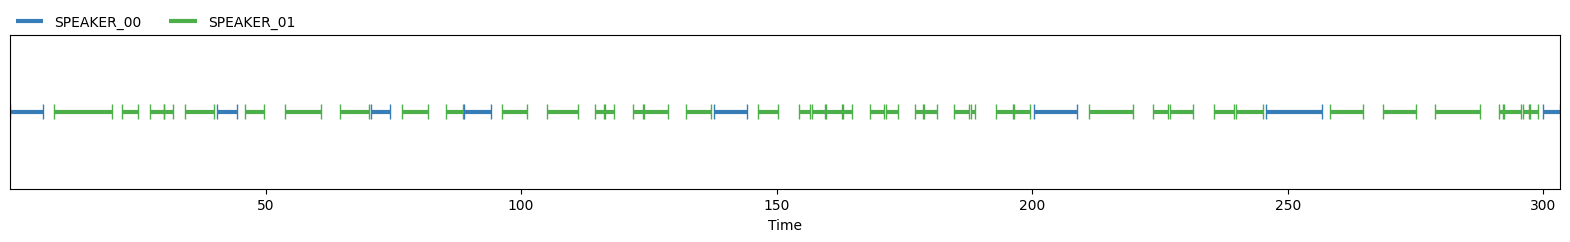

In [30]:
diarization

In [42]:
concatenated_segments = [segment for segment, _, speaker in diarization.itertracks(yield_label=True) if speaker == diarization.argmax()]

In [48]:
for segment in concatenated_segments:
    print(segment.start)
    print(segment.end)

8.633276740237692
19.906621392190154
21.99490662139219
25.0
27.478777589134125
30.07640067911715
30.161290322580648
31.825127334465193
34.30390492359932
39.92359932088285
46.00169779286927
49.77079796264856
53.89643463497453
60.806451612903224
64.54159592529712
70.33106960950764
76.71477079796264
81.74023769100171
85.2207130730051
88.5823429541596
96.29032258064515
101.2478777589134
105.1358234295416
111.12903225806451
114.37181663837012
116.13752122241087
116.37521222410865
118.24278438030561
121.9100169779287
123.77758913412563
124.13412563667234
128.73514431239389
132.3344651952462
137.24108658743634
146.39219015280136
150.36502546689306
154.28692699490662
156.54499151103568
156.86757215619696
159.4482173174873
159.58404074702887
162.7589134125637
162.8947368421053
164.7113752122241
168.34465195246182
170.99320882852294
171.383701188455
173.74363327674024
177.05432937181666
178.616298811545
178.8539898132428
181.33276740237693
184.76230899830222
187.69949066213923
187.9881154499151


In [ ]:
# from TTS.tts.configs.xtts_config import XttsConfig
# from TTS.tts.models.xtts import Xtts

In [5]:
from TTS.api import TTS

In [6]:
tts_model = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to('cuda')

 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
 > Using model: xtts


In [9]:
tts_model.tts_to_file(text="""
                    Few things I wish I said (I'll add items here as they come up):
                    - The dreams and hallucinations do not get fixed with finetuning. Finetuning just "directs" the dreams into "helpful assistant dreams". Always be careful with what LLMs tell you, especially if they are telling you something from memory alone. That said, similar to a human, if the LLM used browsing or retrieval and the answer made its way into the "working memory" of its context window, you can trust the LLM a bit more to process that information into the final answer. But TLDR right now, do not trust what LLMs say or do. For example, in the tools section, I'd always recommend double-checking the math/code the LLM did.
                    - How does the LLM use a tool like the browser? It emits special words, e.g. |BROWSER|. When the code "above" that is inferencing the LLM detects these words it captures the output that follows, sends it off to a tool, comes back with the result and continues the generation. How does the LLM know to emit these special words? Finetuning datasets teach it how and when to browse, by example. And/or the instructions for tool use can also be automatically placed in the context window (in the “system message”).
                    - You might also enjoy my 2015 blog post "Unreasonable Effectiveness of Recurrent Neural Networks". The way we obtain base models today is pretty much identical on a high level, except the RNN is swapped for a Transformer. http://karpathy.github.io/2015/05/21/...
                    - What is in the run.c file? A bit more full-featured 1000-line version hre: https://github.com/karpathy/llama2.c/""",
                file_path="speech.wav",
                speaker_wav=f'{OUTPUT_PATH}/{FILENAME}',
                language="en")

 > Text splitted to sentences.
["Few things I wish I said (I'll add items here as they come up):", '- The dreams and hallucinations do not get fixed with finetuning.', 'Finetuning just "directs" the dreams into "helpful assistant dreams".', 'Always be careful with what LLMs tell you, especially if they are telling you something from memory alone.', 'That said, similar to a human, if the LLM used browsing or retrieval and the answer made its way into the "working memory" of its context window, you can trust the LLM a bit more to process that information into the final answer.', 'But TLDR right now, do not trust what LLMs say or do.', "For example, in the tools section, I'd always recommend double-checking the math/code the LLM did.", '- How does the LLM use a tool like the browser?', 'It emits special words, e.g. |BROWSER|.', 'When the code "above" that is inferencing the LLM detects these words it captures the output that follows, sends it off to a tool, comes back with the result and 

'speech.wav'

In [28]:
# # generate speech by cloning a voice using default settings
# tts.tts_with_vc_to_file(text="""
#                     Few things I wish I said (I'll add items here as they come up):
#                     - The dreams and hallucinations do not get fixed with finetuning. Finetuning just "directs" the dreams into "helpful assistant dreams". Always be careful with what LLMs tell you, especially if they are telling you something from memory alone. That said, similar to a human, if the LLM used browsing or retrieval and the answer made its way into the "working memory" of its context window, you can trust the LLM a bit more to process that information into the final answer. But TLDR right now, do not trust what LLMs say or do. For example, in the tools section, I'd always recommend double-checking the math/code the LLM did.
#                     - How does the LLM use a tool like the browser? It emits special words, e.g. |BROWSER|. When the code "above" that is inferencing the LLM detects these words it captures the output that follows, sends it off to a tool, comes back with the result and continues the generation. How does the LLM know to emit these special words? Finetuning datasets teach it how and when to browse, by example. And/or the instructions for tool use can also be automatically placed in the context window (in the “system message”).
#                     - You might also enjoy my 2015 blog post "Unreasonable Effectiveness of Recurrent Neural Networks". The way we obtain base models today is pretty much identical on a high level, except the RNN is swapped for a Transformer. http://karpathy.github.io/2015/05/21/...
#                     - What is in the run.c file? A bit more full-featured 1000-line version hre: https://github.com/karpathy/llama2.c/""",
#                 file_path="speech.wav",
#                 speaker_wav=f'{OUTPUT_PATH}/{FILENAME}',
#                 language="en")

In [10]:
voice_conv = TTS(model_name="voice_conversion_models/multilingual/vctk/freevc24", progress_bar=True).to("cuda")
voice_conv.voice_conversion_to_file(source_wav="speech.wav", target_wav=f'{OUTPUT_PATH}/{FILENAME}', file_path="speech2.wav")

 > voice_conversion_models/multilingual/vctk/freevc24 is already downloaded.
 > Using model: freevc
 > Loading pretrained speaker encoder model ...
Loaded the voice encoder model on cuda in 0.13 seconds.


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.08 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 7.06 GiB is allocated by PyTorch, and 60.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
tts_model.voice_conversion_to_file(source_wav="speech.wav", target_wav=f'{OUTPUT_PATH}/{FILENAME}', file_path="speech3.wav")

AttributeError: 'NoneType' object has no attribute 'voice_conversion'

In [21]:
tts = TTS("tts_models/en/vctk/vits").to('cuda')

 > tts_models/en/vctk/vits is already downloaded.
 > Using model: vits
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:0
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:None
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:None
 | > symmetric_norm:None
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:None
 | > pitch_fmax:None
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > initialization of speaker-embedding layers.


In [ ]:
tts = TTS(model_name="voice_conversion_models/multilingual/vctk/freevc24", progress_bar=False).to("cuda")
tts.voice_conversion_to_file(source_wav="my/source.wav", target_wav="my/target.wav", file_path="output.wav")

In [25]:
tts.tts_with_vc_to_file(
    """
        Few things I wish I said (I'll add items here as they come up):
        - The dreams and hallucinations do not get fixed with finetuning. Finetuning just "directs" the dreams into "helpful assistant dreams". Always be careful with what LLMs tell you, especially if they are telling you something from memory alone. That said, similar to a human, if the LLM used browsing or retrieval and the answer made its way into the "working memory" of its context window, you can trust the LLM a bit more to process that information into the final answer. But TLDR right now, do not trust what LLMs say or do. For example, in the tools section, I'd always recommend double-checking the math/code the LLM did.
        - How does the LLM use a tool like the browser? It emits special words, e.g. |BROWSER|. When the code "above" that is inferencing the LLM detects these words it captures the output that follows, sends it off to a tool, comes back with the result and continues the generation. How does the LLM know to emit these special words? Finetuning datasets teach it how and when to browse, by example. And/or the instructions for tool use can also be automatically placed in the context window (in the “system message”).
        - You might also enjoy my 2015 blog post "Unreasonable Effectiveness of Recurrent Neural Networks". The way we obtain base models today is pretty much identical on a high level, except the RNN is swapped for a Transformer. http://karpathy.github.io/2015/05/21/...
        - What is in the run.c file? A bit more full-featured 1000-line version hre: https://github.com/karpathy/llama2.c/""",
    file_path="speech2.wav",
    speaker_wav=f'{OUTPUT_PATH}/{FILENAME}',
    # language='en',
    speaker='p225',
)

 > Text splitted to sentences.
["Few things I wish I said (I'll add items here as they come up):", '- The dreams and hallucinations do not get fixed with finetuning.', 'Finetuning just "directs" the dreams into "helpful assistant dreams".', 'Always be careful with what LLMs tell you, especially if they are telling you something from memory alone.', 'That said, similar to a human, if the LLM used browsing or retrieval and the answer made its way into the "working memory" of its context window, you can trust the LLM a bit more to process that information into the final answer.', 'But TLDR right now, do not trust what LLMs say or do.', "For example, in the tools section, I'd always recommend double-checking the math/code the LLM did.", '- How does the LLM use a tool like the browser?', 'It emits special words, e.g. |BROWSER|.', 'When the code "above" that is inferencing the LLM detects these words it captures the output that follows, sends it off to a tool, comes back with the result and 

In [11]:
# tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to('cuda')

In [12]:
# # generate speech by cloning a voice using default settings
# tts.tts_to_file(text="""                    
#                     Few things I wish I said (I'll add items here as they come up):
#                     - The dreams and hallucinations do not get fixed with finetuning. Finetuning just "directs" the dreams into "helpful assistant dreams". Always be careful with what LLMs tell you, especially if they are telling you something from memory alone. That said, similar to a human, if the LLM used browsing or retrieval and the answer made its way into the "working memory" of its context window, you can trust the LLM a bit more to process that information into the final answer. But TLDR right now, do not trust what LLMs say or do. For example, in the tools section, I'd always recommend double-checking the math/code the LLM did.
#                     - How does the LLM use a tool like the browser? It emits special words, e.g. |BROWSER|. When the code "above" that is inferencing the LLM detects these words it captures the output that follows, sends it off to a tool, comes back with the result and continues the generation. How does the LLM know to emit these special words? Finetuning datasets teach it how and when to browse, by example. And/or the instructions for tool use can also be automatically placed in the context window (in the “system message”).
#                     - You might also enjoy my 2015 blog post "Unreasonable Effectiveness of Recurrent Neural Networks". The way we obtain base models today is pretty much identical on a high level, except the RNN is swapped for a Transformer. http://karpathy.github.io/2015/05/21/...
#                     - What is in the run.c file? A bit more full-featured 1000-line version hre: https://github.com/karpathy/llama2.c/""",
#                 file_path="speech.wav",
#                 speaker_wav=f'{OUTPUT_PATH}/{FILENAME}',)
#                 # language="en")

In [ ]:
# config = XttsConfig()
# config.load_json("/path/to/xtts/config.json")
# model = Xtts.init_from_config(config)
# model.load_checkpoint(config, checkpoint_dir="/path/to/xtts/", eval=True)
# model.cuda()

# outputs = model.synthesize(
#     "It took me quite a long time to develop a voice and now that I have it I am not going to be silent.",
#     config,
#     speaker_wav="/data/TTS-public/_refclips/3.wav",
#     gpt_cond_len=3,
#     language="en",
# )